In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import h5py

In [2]:
from des_y6_nz_modeling import (
    nz_binned_to_interp,
    compute_nz_binned_mean,
    compute_lin_interp_mean,
)

In [3]:
with h5py.File("N_gamma_alpha_v1.hdf5") as d:
    z = d["redshift/true/zbinsc"][:].astype(np.float64)[1:]
    nzs = {}
    for _bin in range(4):
        nzs[_bin] = d[f"redshift/true/bin{_bin}"][:].astype(np.float64)[1:]

DZ = z[1] - z[0]
Z0 = z[0]

assert np.allclose(DZ, 0.05)
assert np.allclose(Z0, 0.035)


In [5]:
print("bin   mn05         mn01         shift")

shifts = {}
for _bin in range(4):
    nz = nzs[_bin]
    nz /= np.sum(nz)

    mn05 = compute_nz_binned_mean(nz, DZ, Z0)

    z, dndz = nz_binned_to_interp(nz, DZ, Z0)
    zhr = np.arange(0.0, 4, 0.01)
    dndzhr = np.interp(zhr, z, dndz, left=0, right=0)
    mn01 = compute_lin_interp_mean(zhr, dndzhr)

    shifts[_bin] = {"mn05": mn05, "mn01": mn01}

    print(f"{_bin: 3d} {mn05: 12.8f} {mn01: 12.8f} {mn01 - mn05: 12.8e}")

bin   mn05         mn01         shift
  0   0.35137865   0.35143923  6.05810680e-05
  1   0.50898812   0.50899682  8.69600971e-06
  2   0.78432162   0.78433202  1.04000302e-05
  3   1.06991688   1.07000504  8.81596043e-05


In [2]:
from jax.nn import sigmoid

import ultraplot as uplt

<a list of 1 Line2D objects>

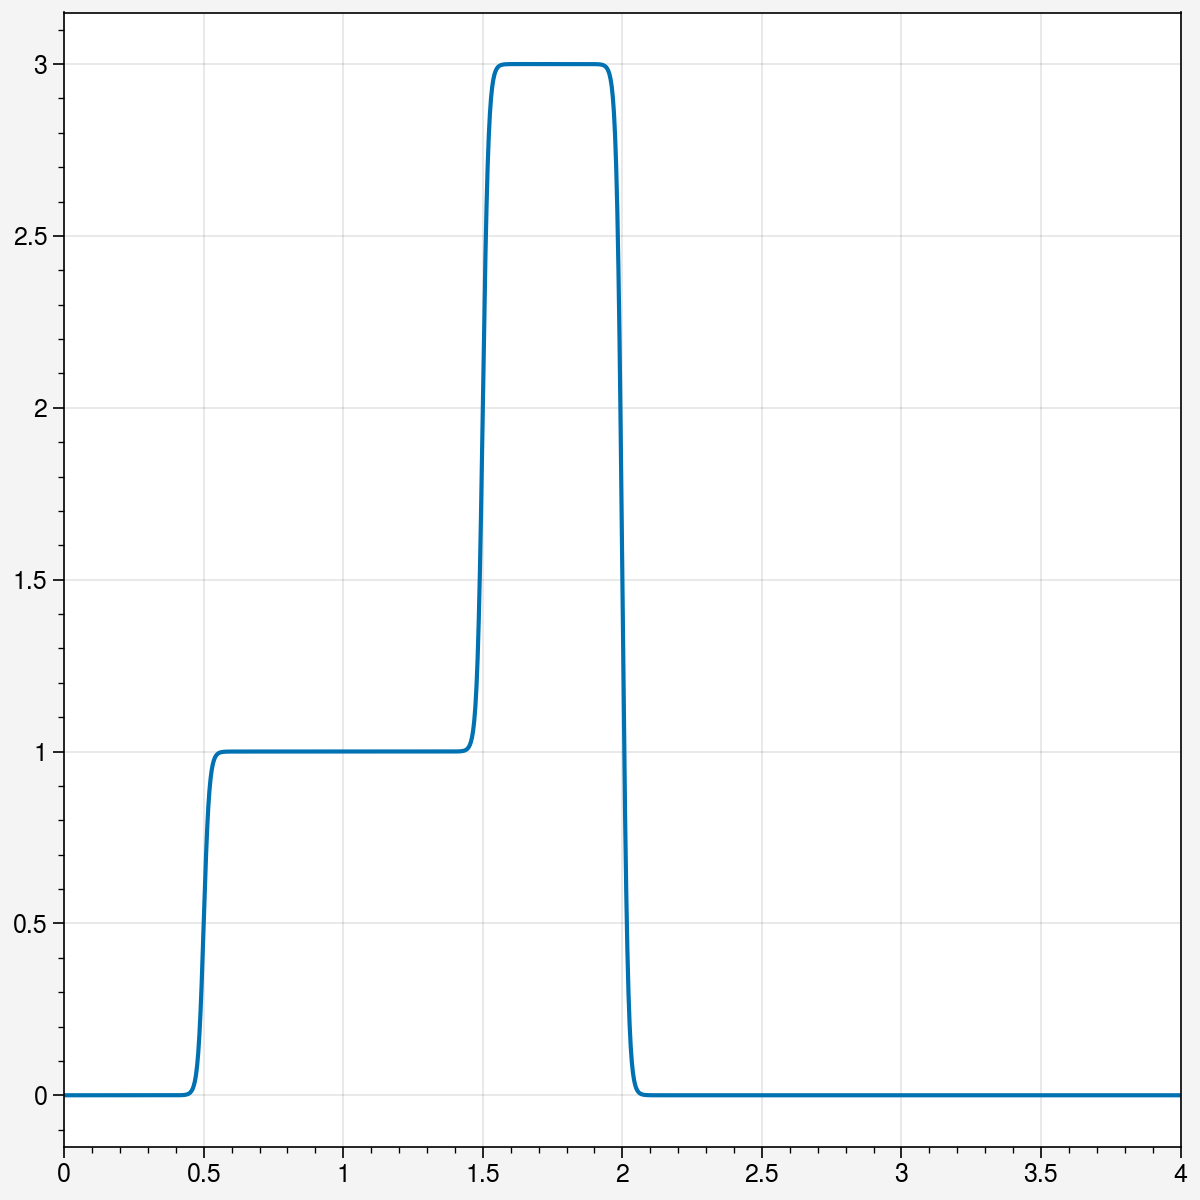

In [8]:
def bump(z, a, b, w):
    return sigmoid((z - a) / w) * (1 - sigmoid((z - b) / w))

fig, axs = uplt.subplots(figsize=(6, 6))

z = np.linspace(0, 4, 1000)
axs.plot(z, bump(z, 0.5, 1.5, 0.01) + 3 * bump(z, 1.5, 2.0, 0.01), label="bump")